# Dataset Analysis

In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from termcolor import colored
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize


df = pd.read_csv('../../data/tweets.csv')

### Duplicate analysis

Firstly, we check if the dataset contains any duplicated rows, so rows that are completely identical (same "tweet_text" and cyberbullying_type").

In [68]:
print(f"The number of duplicated tweets in the same category is: {df.duplicated().sum() * 2}")

The number of duplicated tweets in the same category is: 72


The next step is to investigate whether there are tweets that have identical text but are assigned different types of cyberbullying.

In [12]:
print(f"The number of tweets that have same text but different category is: {df.duplicated(subset=['tweet_text']).sum() * 2}")
d = df[df.duplicated(subset=['tweet_text'], keep = False)]      

The number of tweets that have same text but different category is: 3350


Let's analyse how these tweets are divided for each category.

In [13]:
print(f"In the category religion, there are {len(d[d['cyberbullying_type']=='religion'])} duplicates.")

In the category religion, there are 8 duplicates.


In [14]:
print(f"In the category ethnicity, there are {len(d[d['cyberbullying_type']=='ethnicity'])} duplicates.")

In the category ethnicity, there are 11 duplicates.


In [15]:
print(f"In the category age, there are {len(d[d['cyberbullying_type']=='age'])} duplicates.")

In the category age, there are 0 duplicates.


In [16]:
print(f"In the category not_cyberbullying, there are {len(d[d['cyberbullying_type']=='not_cyberbullying'])} duplicates.")

In the category not_cyberbullying, there are 1525 duplicates.


In [17]:
print(f"In the category other_cyberbullying, there are {len(d[d['cyberbullying_type']=='other_cyberbullying'])} duplicates.")

In the category other_cyberbullying, there are 1580 duplicates.


We can see that most duplicates are in the last two categories, not cyberbullying and other cyberbullying. We want to check how many duplicates these two share, so how many tweets have the same text and are assigned to both these categories.

In [18]:
dataset = d[(d['cyberbullying_type'] == 'other_cyberbullying') | (d['cyberbullying_type'] == 'not_cyberbullying')]
dataset.duplicated(subset=['tweet_text']).sum()

1464

This is a huge number: this means that the two categories share 1464 tweets. This means that for a classification model, the classifying task become difficult when having to distinguish these two. For this reason, we drop the category other cyberbullying.

In [ ]:
def drop_other_cyberbullying(df):
    # Drop duplicates and other_cyberbullying tweets
    df = df.drop_duplicates()
    df = df[df['cyberbullying_type'] != 'other_cyberbullying']
    return df

In [ ]:
df = drop_other_cyberbullying(df)
df.to_csv(r"../../data/updated_tweets.csv", index=False)

### Dataset Analysis

Let's see how the tweet categories are distributed after the duplicate removal.

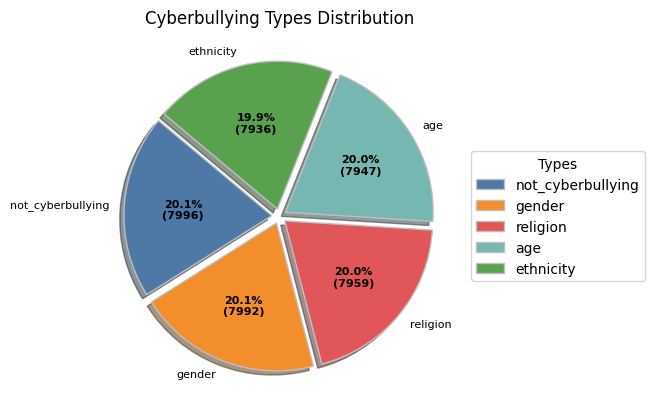

In [42]:
df = pd.read_csv('../../data/updated_tweets.csv')

cyberbullying_types = df['cyberbullying_type'].unique()
cyt_values = df['cyberbullying_type'].value_counts().values

# Select a more classic color palette
colors = ["#4E79A7", "#F28E2B", "#E15759", "#76B7B2", "#59A14F", "#EDC948", "#B07AA1", "#FF9DA7", "#9C755F", "#BAB0AC"]

# Uniform explode to slightly separate the slices
explode = (0.05,) * len(cyberbullying_types)  # Uniform slight explode for each slice

# Wedge properties
wp = {'linewidth': 1, 'edgecolor': "silver"}

# Autopct function to format the label texts
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating the pie chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    cyt_values,
    autopct=lambda pct: func(pct, cyt_values),
    explode=explode,
    labels=cyberbullying_types,
    shadow=True,
    colors=colors,
    startangle=140,
    wedgeprops=wp,
    textprops={'fontsize': 8}
)

# Legend
ax.legend(wedges, cyberbullying_types,
          title="Types",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

# Set the automatic text properties and title
plt.setp(autotexts, size=8, weight="bold", color="black")
ax.set_title("Cyberbullying Types Distribution")

# Show the plot
plt.show()


We notice that the dataset still is balanced.

Let's plot some wordclouds of the different categories.

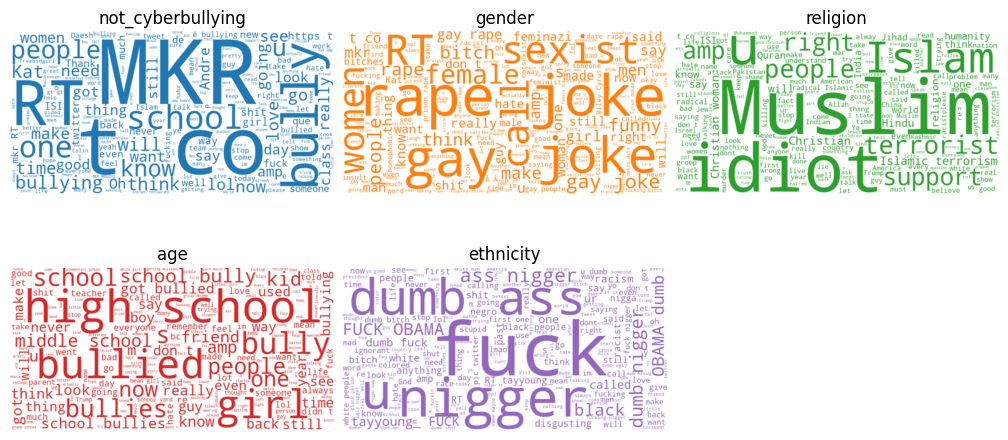

In [12]:
plt.figure(figsize=(10, 5))

# Color scheme for each word cloud
color_scheme = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# For each cyberbullying type:
for i, type_name in enumerate(cyberbullying_types):
    # Filter tweets by type
    tweets = df[df['cyberbullying_type'] == type_name]
    
    # Concatenate all tweets into a single string using space as separator 
    text = tweets['tweet_text'].map('{} '.format).sum()

    # Create and generate a word cloud image with specific color
    wordcloud = WordCloud(background_color='white', 
                          mode="RGB", 
                          width=800, 
                          height=400,
                          color_func=lambda *args, **kwargs: color_scheme[i]).generate(text)

    # Display the generated image:
    plt.subplot(2, 3, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(type_name)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()


Let's look at the length distirbution of the different tweets.

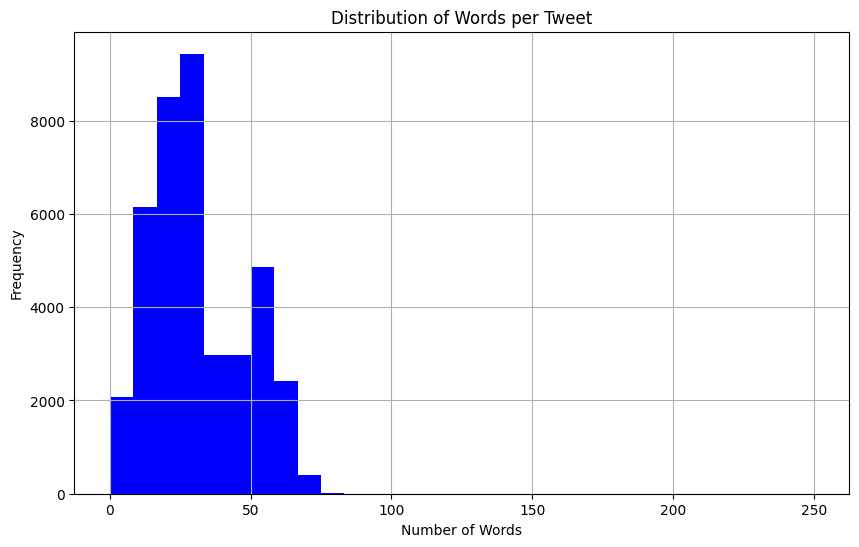

In [63]:
# Correctly applying the word_tokenize function
df['word_count'] = df['tweet_text'].apply(lambda x: len(word_tokenize(x)))

# Plotting the distribution of word counts
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=30, color='blue', range=(0,250))
plt.title('Distribution of Words per Tweet')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Let's look at the word length distribution in different tweets.

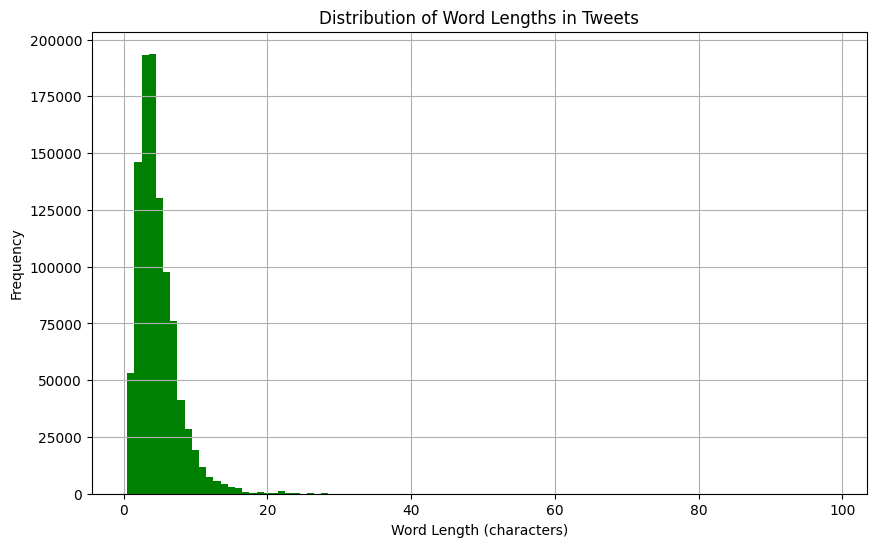

In [66]:
# Splitting tweets into words and calculating the length of each word
df['word_lengths'] = df['tweet_text'].apply(lambda x: [len(word) for word in x.split()])

# Flattening the list of word lengths to create a histogram
all_word_lengths = np.hstack(df['word_lengths'])

plt.figure(figsize=(10, 6))
plt.hist(all_word_lengths, bins=range(1, 100), color='green', align='left')
plt.title('Distribution of Word Lengths in Tweets')
plt.xlabel('Word Length (characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [39]:
# Finding the tweet with the longest word
df['max_word_length'] = df['word_lengths'].apply(max)
longest_word_tweet = df[df['max_word_length'] == df['max_word_length'].max()]['tweet_text'].iloc[0]
print("Tweet with the longest word:", longest_word_tweet)

Tweet with the longest word: https://www-dailymail-co-uk.cdn.ampproject.org/v/s/www.dailymail.co.uk/news/article-8390201/amp/Pictured-Suspect-20-stabbed-cop-anti-looting-watch-neck-Brooklyn.html?amp_js_v=a3&amp;amp_gsa=1&amp;usqp=mq331AQFKAGwASA%3D#aoh=15915270850421&amp;referrer=https%3A%2F%2Fwww.google.com&amp;amp_tf=From%20%251%24s&amp;ampshare=https%3A%2F%2Fwww.dailymail.co.uk%2Fnews%2Farticle-8390201%2FPictured-Suspect-20-stabbed-cop-anti-looting-watch-neck-Brooklyn.html [Islamic terrorism: MO-knife jihad attack on NYPD officer as jihadi hollers Allah-u-akbar, gave allegiance to Allah]


Let's look at the most frequent words (considering only how many time they appear).

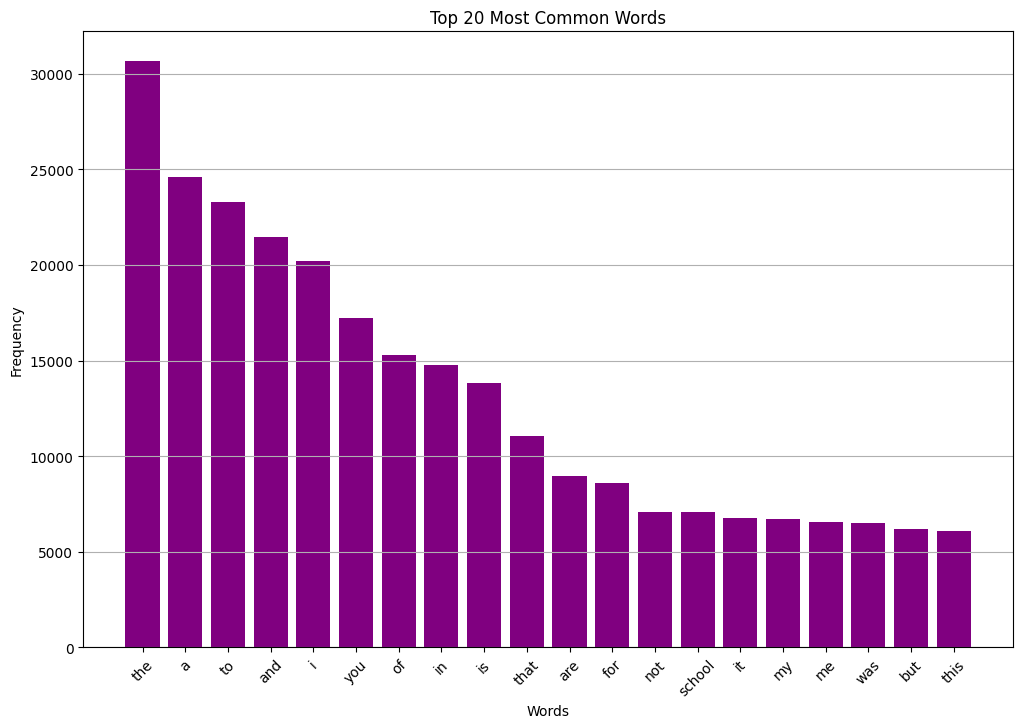

In [28]:
# Counting word occurrences
word_counts = Counter(word for tweet in df['tweet_text'] for word in tweet.lower().split())

# Most common words
most_common_words = word_counts.most_common(20)

# Plotting
plt.figure(figsize=(12, 8))
plt.bar([word for word, _ in most_common_words], [count for _, count in most_common_words], color='purple')
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

This is expected, as the dataset has not gone through any preprocessing for the moment.

Let's look at the most frequent words (considering TF-Idf).

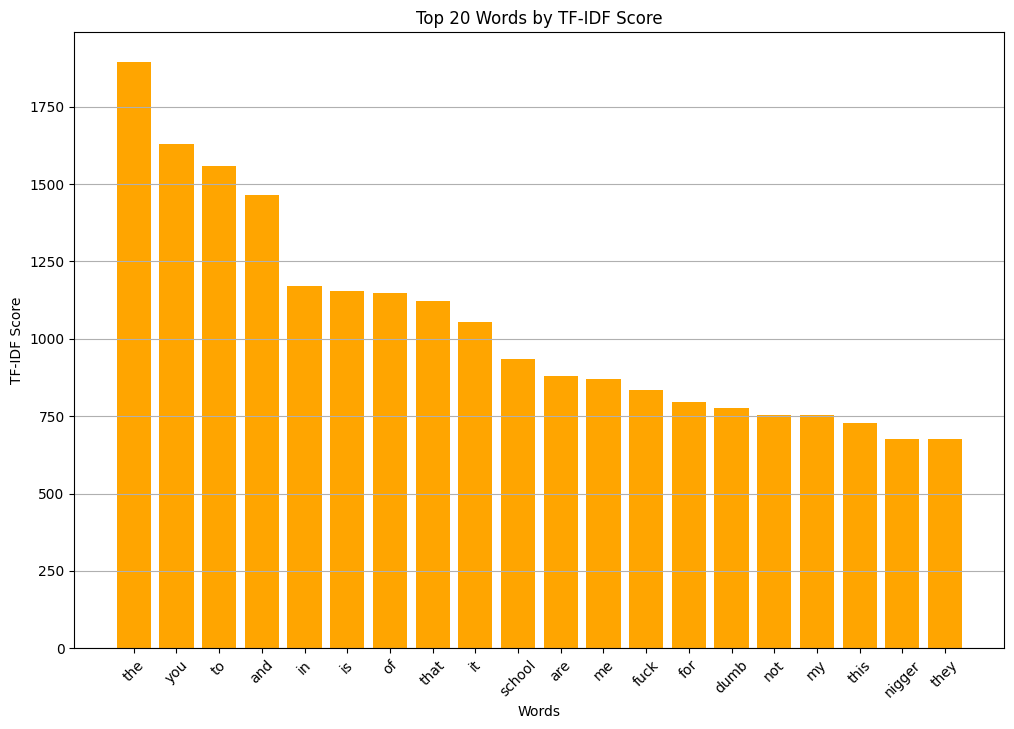

In [31]:
# Creating TF-IDF scores for each word in the corpus
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['tweet_text'])
tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))

# Visualizing the highest TF-IDF scores
sorted_tfidf = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:20]

plt.figure(figsize=(12, 8))
plt.bar([x[0] for x in sorted_tfidf], [x[1] for x in sorted_tfidf], color='orange')
plt.title('Top 20 Words by TF-IDF Score')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Still, the results are very general, but we can see that by considering TF-IDF and not only the scores, some interesting and more domain-specific words appear.

### Dataset split

After splitting the dataset, we realized that we did not set a seed for reproducibility, so running this code will yield a different result compared to the dataset we worked on. Despite this, the proportions we used are as follows: we first divided the dataset into training (80%) and testing (20%), and then we used 20% of the training set as validation.

In [ ]:
def split_dataset(input_file, train_file, eval_file, test_file, train_size=0.8, eval_size=0.2):
    # Dataset loading
    df = pd.read_csv(input_file)
    
    # Split between training and test
    train_df, test_df = train_test_split(df, train_size=train_size)
    
    # Split between training and validation
    train_df, eval_df = train_test_split(train_df, train_size=1 - eval_size)
    
    # Save the dataframes
    train_df.to_csv(train_file, index=False)
    eval_df.to_csv(eval_file, index=False)
    test_df.to_csv(test_file, index=False)

Let's check if all datasets are balanced.

In [5]:
print("Training set")
print()
prova1 = pd.read_csv('../../data/train_tweets.csv')
print(f"Tweet classified as not cyberbullying", end=" ")
print(colored(len(prova1[prova1['cyberbullying_type']=='not_cyberbullying']), "blue"))
print(f"Tweet classified as religion", end=" ")
print(colored(len(prova1[prova1['cyberbullying_type']=='religion']), "blue"))
print(f"Tweet classified as age", end=" ")
print(colored(len(prova1[prova1['cyberbullying_type']=='age']), "blue"))
print(f"Tweet classified as ethnicity", end=" ")
print(colored(len(prova1[prova1['cyberbullying_type']=='ethnicity']), "blue"))
print(f"Tweet classified as gender ", end=" ")
print(colored(len(prova1[prova1['cyberbullying_type']=='gender']), "blue"))

Training set

Tweet classified as not cyberbullying 5082
Tweet classified as religion 5069
Tweet classified as age 5126
Tweet classified as ethnicity 5124
Tweet classified as gender  5091


In [6]:
print("Validation set")
print()
prova2 = pd.read_csv('../../data/eval_tweets.csv')
print(f"Tweet classified as not cyberbullying", end=" ")
print(colored(len(prova2[prova2['cyberbullying_type']=='not_cyberbullying']), "blue"))
print(f"Tweet classified as religion", end=" ")
print(colored(len(prova2[prova2['cyberbullying_type']=='religion']), "blue"))
print(f"Tweet classified as age", end=" ")
print(colored(len(prova2[prova2['cyberbullying_type']=='age']), "blue"))
print(f"Tweet classified as ethnicity", end=" ")
print(colored(len(prova2[prova2['cyberbullying_type']=='ethnicity']), "blue"))
print(f"Tweet classified as gender ", end=" ")
print(colored(len(prova2[prova2['cyberbullying_type']=='gender']), "blue"))

Validation set

Tweet classified as not cyberbullying 1263
Tweet classified as religion 1304
Tweet classified as age 1270
Tweet classified as ethnicity 1294
Tweet classified as gender  1243


In [7]:
print("Test set")
print()
prova3 = pd.read_csv('../../data/test_tweets.csv')
print(f"Tweet classified as not cyberbullying", end=" ")
print(colored(len(prova3[prova3['cyberbullying_type']=='not_cyberbullying']), "blue"))
print(f"Tweet classified as religion", end=" ")
print(colored(len(prova3[prova3['cyberbullying_type']=='religion']), "blue"))
print(f"Tweet classified as age", end=" ")
print(colored(len(prova3[prova3['cyberbullying_type']=='age']), "blue"))
print(f"Tweet classified as ethnicity", end=" ")
print(colored(len(prova3[prova3['cyberbullying_type']=='ethnicity']), "blue"))
print(f"Tweet classified as gender ", end=" ")
print(colored(len(prova3[prova3['cyberbullying_type']=='gender']), "blue"))

Test set

Tweet classified as not cyberbullying 1592
Tweet classified as religion 1624
Tweet classified as age 1596
Tweet classified as ethnicity 1541
Tweet classified as gender  1614
